#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Sparse Data and Embeddings

**Learning Objectives:**
* Convert movie-review string data to a sparse feature vector
* Implement a sentiment-analysis linear model using a sparse feature vector
* Implement a sentiment-analysis DNN model using an embedding that projects data into two dimensions
* Visualize the embedding to see what the model has learned about the relationships between words

In this exercise, we'll explore sparse data and work with embeddings using text data from movie reviews (from the [ACL 2011 IMDB dataset](http://ai.stanford.edu/~amaas/data/sentiment/)). This data has already been processed into `tf.Example` format.  

## Setup

Let's import our dependencies and download the training and test data. [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) includes a file download and caching tool that we can use to retrieve the data sets.

In [2]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

40697856/40688441 [==============================] - 0s 0us/step


## Building a Sentiment Analysis Model

Let's train a sentiment-analysis model on this data that predicts if a review is generally *favorable* (label of 1) or *unfavorable* (label of 0).

To do so, we'll turn our string-value `terms` into feature vectors by using a *vocabulary*, a list of each term we expect to see in our data. For the purposes of this exercise, we've created a small vocabulary that focuses on a limited set of terms. Most of these terms were found to be strongly indicative of *favorable* or *unfavorable*, but some were just added because they're interesting.

Each term in the vocabulary is mapped to a coordinate in our feature vector. To convert the string-value `terms` for an example into this vector format, we encode such that each coordinate gets a value of 0 if the vocabulary term does not appear in the example string, and a value of 1 if it does. Terms in an example that don't appear in the vocabulary are thrown away.

**NOTE:** *We could of course use a larger vocabulary, and there are special tools for creating these. In addition, instead of just dropping terms that are not in the vocabulary, we can introduce a small number of OOV (out-of-vocabulary) buckets to which you can hash the terms not in the vocabulary. We can also use a __feature hashing__ approach that hashes each term, instead of creating an explicit vocabulary. This works well in practice, but loses interpretability, which is useful for this exercise. See see the tf.feature_column module for tools handling this.*

## Building the Input Pipeline

First, let's configure the input pipeline to import our data into a TensorFlow model. We can use the following function to parse the training and test data (which is in [TFRecord](https://www.tensorflow.org/guide/datasets#consuming_tfrecord_data) format) and return a dict of the features and the corresponding labels.

In [0]:
def _parse_function(record):
  """Extracts features and labels.
  
  Args:
    record: File path to a TFRecord file    
  Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
  """
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }
  
  parsed_features = tf.parse_single_example(record, features)
  
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']

  return  {'terms':terms}, labels

To confirm our function is working as expected, let's construct a `TFRecordDataset` for the training data, and map the data to features and labels using the function above.

In [4]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(train_path)
# Map features and labels with the parse function.
ds = ds.map(_parse_function)

ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

Run the following cell to retrieve the first example from the training data set.

In [5]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array(['but', 'it', 'does', 'have', 'some', 'good', 'action', 'and', 'a',
         'plot', 'that', 'is', 'somewhat', 'interesting', '.', 'nevsky',
         'acts', 'like', 'a', 'body', 'builder', 'and', 'he', 'isn', "'",
         't', 'all', 'that', 'attractive', ',', 'in', 'fact', ',', 'imo',
         ',', 'he', 'is', 'ugly', '.', '(', 'his', 'acting', 'skills',
         'lack', 'everything', '!', ')', 'sascha', 'is', 'played', 'very',
         'well', 'by', 'joanna', 'pacula', ',', 'but', 'she', 'needed',
         'more', 'lines', 'than', 'she', 'was', 'given', ',', 'her',
         'character', 'needed', 'to', 'be', 'developed', '.', 'there',
         'are', 'way', 'too', 'many', 'men', 'in', 'this', 'story', ',',
         'there', 'is', 'zero', 'romance', ',', 'too', 'much', 'action',
         ',', 'and', 'way', 'too', 'dumb', 'of', 'an', 'ending', '.', 'it',
         'is', 'very', 'violent', '.', 'i', 'did', 'however', 'love', 'the',
         'scenery', ',', 'this', 'mov

Now, let's build a formal input function that we can pass to the `train()` method of a TensorFlow Estimator object.

In [0]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
  # Same code as above; create a dataset and map features and labels.
  ds = tf.data.TFRecordDataset(input_filenames)
  ds = ds.map(_parse_function)

  if shuffle:
    ds = ds.shuffle(10000)

  # Our feature data is variable-length, so we pad and batch
  # each field of the dataset structure to whatever size is necessary.
  ds = ds.padded_batch(25, ds.output_shapes)
  
  ds = ds.repeat(num_epochs)

  
  # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

## Task 1: Use a Linear Model with Sparse Inputs and an Explicit Vocabulary

For our first model, we'll build a [`LinearClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) model using 50 informative terms; always start simple!

The following code constructs the feature column for our terms. The [`categorical_column_with_vocabulary_list`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list) function creates a feature column with the string-to-feature-vector mapping.

In [0]:
# 50 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

Next, we'll construct the `LinearClassifier`, train it on the training set, and evaluate it on the evaluation set. After you read through the code, run it and see how you do.

In [8]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]


classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 11.268292
accuracy_baseline 0.5
global_step 1000
recall 0.82416
auc 0.8720522
prediction/mean 0.49554762
precision 0.7693227
label/mean 0.5
average_loss 0.45073166
auc_precision_recall 0.8637363
accuracy 0.78852
---
Test set metrics:
loss 11.273576
accuracy_baseline 0.5
global_step 1000
recall 0.82
auc 0.8705363
prediction/mean 0.49384958
precision 0.7674453
label/mean 0.5
average_loss 0.45094305
auc_precision_recall 0.86173487
accuracy 0.78576
---


## Task 2: Use a Deep Neural Network (DNN) Model

The above model is a linear model.  It works quite well.  But can we do better with a DNN model?

Let's swap in a [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) for the `LinearClassifier`. Run the following cell, and see how you do.

In [9]:
##################### Here's what we changed ##################################
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)                                                                             #
###############################################################################

try:
  classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

Training set metrics:
loss 16.797188
accuracy_baseline 0.56
global_step 1000
recall 0.90909094
auc 0.7142857
prediction/mean 0.60743326
precision 0.5555556
label/mean 0.44
average_loss 0.6718875
auc_precision_recall 0.7118259
accuracy 0.64
---
Test set metrics:
loss 10.893993
accuracy_baseline 0.52
global_step 1000
recall 1.0
auc 0.87499994
prediction/mean 0.6063657
precision 0.7647059
label/mean 0.52
average_loss 0.43575972
auc_precision_recall 0.86840075
accuracy 0.84
---


## Task 3: Use an Embedding with a DNN Model

In this task, we'll implement our DNN model using an embedding column. An embedding column takes sparse data as input and returns a lower-dimensional dense vector as output.

**NOTE:** *An embedding_column is usually the computationally most efficient option to use for training a model on sparse data. In an [optional section](#scrollTo=XDMlGgRfKSVz) at the end of this exercise, we'll discuss in more depth the implementational differences between using an `embedding_column` and an `indicator_column`, and the tradeoffs of selecting one over the other.*

In the following code, do the following:

* Define the feature columns for the model using an `embedding_column` that projects the data into 2 dimensions (see the [TF docs](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) for more details on the function signature for `embedding_column`).
* Define a `DNNClassifier` with the following specifications:
  * Two hidden layers of 20 units each
  * Adagrad optimization with a learning rate of 0.1
  * A `gradient_clip_norm` of 5.0

**NOTE:** *In practice, we might project to dimensions higher than 2, like 50 or 100.  But for now, 2 dimensions is easy to visualize.*

### Hint

In [0]:
# Here's a example code snippet you might use to define the feature columns:

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

### Complete the Code Below

In [12]:
########################## YOUR CODE HERE ######################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20,20],
  optimizer=my_optimizer)
################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 11.310725
accuracy_baseline 0.5
global_step 1000
recall 0.7916
auc 0.86889654
prediction/mean 0.49213958
precision 0.7837624
label/mean 0.5
average_loss 0.45242903
auc_precision_recall 0.85731965
accuracy 0.7866
---
Test set metrics:
loss 11.315334
accuracy_baseline 0.5
global_step 1000
recall 0.78544
auc 0.8688604
prediction/mean 0.4919113
precision 0.7824355
label/mean 0.5
average_loss 0.45261335
auc_precision_recall 0.85737497
accuracy 0.78352
---


## Task 4: Convince yourself there's actually an embedding in there

The above model used an `embedding_column`, and it seemed to work, but this doesn't tell us much about what's going on internally. How can we check that the model is actually using an embedding inside?

To start, let's look at the tensors in the model:

In [13]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

Okay, we can see that there is an embedding layer in there: `'dnn/input_from_feature_columns/input_layer/terms_embedding/...'`. (What's interesting here, by the way, is that this layer is trainable along with the rest of the model just as any hidden layer is.)

Is the embedding layer the correct shape? Run the following code to find out.

**NOTE:** *Remember, in our case, the embedding is a matrix that allows us to project a 50-dimensional vector down to 2 dimensions.*

In [14]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

Spend some time manually checking the various layers and shapes to make sure everything is connected the way you would expect it would be.

## Task 5: Examine the Embedding

Let's now take a look at the actual embedding space, and see where the terms end up in it. Do the following:
1. Run the following code to see the embedding we trained in **Task 3**. Do things end up where you'd expect?

2. Re-train the model by rerunning the code in **Task 3**, and then run the embedding visualization below again. What stays the same? What changes?

3. Finally, re-train the model again using only 10 steps (which will yield a terrible model). Run the embedding visualization below again. What do you see now, and why?

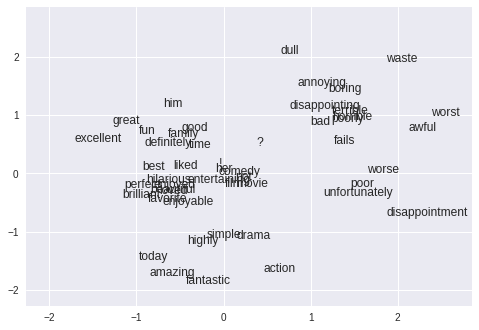

In [15]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term. It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

## Task 6:  Try to improve the model's performance

See if you can refine the model to improve performance. A couple things you may want to try:

* **Changing hyperparameters**, or **using a different optimizer** like Adam (you may only gain one or two accuracy percentage points following these strategies).
* **Adding additional terms to `informative_terms`.** There's a full vocabulary file with all 30,716 terms for this data set that you can use at: https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/terms.txt You can pick out additional terms from this vocabulary file, or use the whole thing via the `categorical_column_with_vocabulary_file` feature column.

In [0]:
# Download the vocabulary file.
terms_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

In [19]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
  # Convert it to a set first to remove duplicates.
  informative_terms = list(set(f.read().split()))
  
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
loss 9.706233
accuracy_baseline 0.5
global_step 1000
recall 0.7684
auc 0.91315573
prediction/mean 0.44575265
precision 0.87700874
label/mean 0.5
average_loss 0.38824934
auc_precision_recall 0.91024125
accuracy 0.83032
---
Test set metrics:
loss 10.247194
accuracy_baseline 0.5
global_step 1000
recall 0.7476
auc 0.9022474
prediction/mean 0.44369248
precision 0.86248267
label/mean 0.5
average_loss 0.40988776
auc_precision_recall 0.8995676
accuracy 0.8142
---


## A Final Word

We may have gotten a DNN solution with an embedding that was better than our original linear model, but the linear model was also pretty good and was quite a bit faster to train. Linear models train more quickly because they do not have nearly as many parameters to update or layers to backprop through.

In some applications, the speed of linear models may be a game changer, or linear models may be perfectly sufficient from a quality standpoint. In other areas, the additional model complexity and capacity provided by DNNs might be more important. When defining your model architecture, remember to explore your problem sufficiently so that you know which space you're in.

### *Optional Discussion:* Trade-offs between `embedding_column` and `indicator_column`

Conceptually when training a `LinearClassifier` or a `DNNClassifier`, there is an adapter needed to use a sparse column. TF provides two options: `embedding_column` or `indicator_column`.

When training a LinearClassifier (as in **Task 1**), an `embedding_column` in used under the hood. As seen in **Task 2**, when training a `DNNClassifier`, you must explicitly choose either `embedding_column` or `indicator_column`. This section discusses the distinction between the two, and the trade-offs of using one over the other, by looking at a simple example.

Suppose we have sparse data containing the values `"great"`, `"beautiful"`, `"excellent"`. Since the vocabulary size we're using here is $V = 50$, each unit (neuron) in the first layer will have 50 weights. We denote the number of terms in a sparse input using $s$. So for this example sparse data, $s = 3$. For an input layer with $V$ possible values, a hidden layer with $d$ units needs to do a vector-matrix multiply: $(1 \times V) * (V \times d)$.  This has $O(V * d)$ computational cost. Note that this cost is proportional to the number of weights in that hidden layer and independent of $s$.

If the inputs are one-hot encoded (a Boolean vector of length $V$ with a 1 for the terms present and a 0 for the rest) using an [`indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column), this means multiplying and adding a lot of zeros.

When we achieve the exact same results by using an [`embedding_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) of size $d$, we look up and add up just the embeddings corresponding to the three features present in our example input of "`great`", "`beautiful`", "`excellent`": $(1 \times d) + (1 \times d) + (1 \times d)$. Since the weights for the features that are absent are multiplied by zero in the vector-matrix multiply, they do not contribute to the result. Weights for the features that are present are multiplied by 1 in the vector-matrix multiply. Thus, adding the weights obtained via the embedding lookup will lead to the same result as in the vector-matrix-multiply.

When using an embedding, computing the embedding lookup is an $O(s * d)$ computation, which is computationally much more efficient than the $O(V * d)$ cost for the `indicator_column` in sparse data for which $s$ is much smaller than $V$. (Remember, these embeddings are being learned. In any given training iteration it is the current weights that are being looked up.)

As we saw in **Task 3**, by using an `embedding_column` in training the `DNNClassifier`, our model learns a low-dimensional representation for the features, where the dot product defines a similarity metric tailored to the desired task. In this example, terms that are used similarly in the context of movie reviews (e.g., `"great"` and `"excellent"`) will be closer to each other the embedding space (i.e., have a large dot product), and terms that are dissimilar (e.g., `"great"` and `"bad"`) will be farther away from each other in the embedding space (i.e., have a small dot product).